# LOFAR single station imaging

Based on version 1.4 of V.A. Moss's tutorial, tutorial from M.A. Brentjens 8/8/2017.

Updated February 2020 by T.J. Dijkema with aerial imagery backdrops.

This notebook is intended to explore the imaging of one XST file. To do all of the things in this notebook for a batch of XST files, have a look at the function `make_xst_plots` (`from lofarimaging import make_xst_plots`).

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
import os
import sys
import time
import datetime
import glob
import numpy as np

import sys
sys.path.append('..')

from lofarantpos.db import LofarAntennaDatabase

In [36]:
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, Normalize
import warnings
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.axes as maxes
from matplotlib.ticker import FormatStrFormatter
import re

In [37]:
from astropy.coordinates import SkyCoord, GCRS, EarthLocation, AltAz, SkyOffsetFrame, CartesianRepresentation, get_sun#, get_moon
import astropy.units as u
from astropy.time import Time

In [38]:
# We need lofarantpos >= 0.4.0 to get the station rotations

from packaging import version
import lofarantpos
assert(version.parse(lofarantpos.__version__) >= version.parse("0.4.0"))

In [39]:
from lofarimaging import find_caltable, sb_from_freq, freq_from_sb, read_caltable, \
    read_acm_cube, get_map, sky_imager, ground_imager, get_station_pqr, get_station_type, \
    skycoord_to_lmn, nearfield_imager, make_leaflet_map, make_sky_plot, make_ground_plot, \
    apply_calibration, get_full_station_name, get_station_xyz

In [40]:
# We need python 3.6 for f-string formatting


assert(sys.version_info.major + 0.1*sys.version_info.minor >= 3.6)

In [41]:
base_dir = "/home/jan/Documents/LV614_image_data"
#data_dir = "./test"
#data_dir = "sess_sid20230106T105202_LV614/scan_59950.45281/LV614_20230106_105219_spw3_sb51_461_int1_dur8700_dir0,0,JUPITER_bst/"
#data_dir = "/sess_sid20230106T105202_LV614/scan_59950.45281/LV614_20230106_110049_spw3_int1_dur512_dir0,0,JUPITER_acc/"
data_dir = base_dir + "/sess_sid20230111T071252_LV614/scan_59955.30061/LV614_20230111_071256_spw3_sb51_461_int1_dur24300_dir0,0,SUN_xst/"
#data_dir = "/sess_sid20220913T112630_LV614/scan_59835.47674/LV614_20220913_113334_spw3_sb51_461_int1_dur411_dirCas-A_xst/"


#caltable_dir = "./test/CalTables"  # Root directory under which station information is stored in subdirectories DE602C/etc/, RS106/etc/, ...
caltable_dir = base_dir + "/CalTables/"

In [42]:
extent = [-150, 150, -150, 150]
pixels_per_metre = 0.5
height = 1.5

In [43]:
os.makedirs('results', exist_ok=True)

In [44]:
start1 = time.time()

In [45]:
# Read all available .dat files
print(f"Searching for available files in {data_dir}")
files = glob.glob(data_dir + "/*.dat")
for file_index, filename in enumerate(files):
    print(f"{file_index}: {filename}")

Searching for available files in /home/jan/Documents/LV614_image_data/sess_sid20230111T071252_LV614/scan_59955.30061/LV614_20230111_071256_spw3_sb51_461_int1_dur24300_dir0,0,SUN_xst/
0: /home/jan/Documents/LV614_image_data/sess_sid20230111T071252_LV614/scan_59955.30061/LV614_20230111_071256_spw3_sb51_461_int1_dur24300_dir0,0,SUN_xst/20230111_135754_xst.dat
1: /home/jan/Documents/LV614_image_data/sess_sid20230111T071252_LV614/scan_59955.30061/LV614_20230111_071256_spw3_sb51_461_int1_dur24300_dir0,0,SUN_xst/20230111_135752_xst.dat
2: /home/jan/Documents/LV614_image_data/sess_sid20230111T071252_LV614/scan_59955.30061/LV614_20230111_071256_spw3_sb51_461_int1_dur24300_dir0,0,SUN_xst/20230111_135750_xst.dat
3: /home/jan/Documents/LV614_image_data/sess_sid20230111T071252_LV614/scan_59955.30061/LV614_20230111_071256_spw3_sb51_461_int1_dur24300_dir0,0,SUN_xst/20230111_135746_xst.dat
4: /home/jan/Documents/LV614_image_data/sess_sid20230111T071252_LV614/scan_59955.30061/LV614_20230111_071256_spw3

In [46]:
# Select a file
#xst_filename = "../image_data/sess_sid20230106T105202_LV614/scan_59950.45281/LV614_20230106_105219_spw3_sb51_461_int1_dur8700_dir0,0,JUPITER_bst/20230106_105219_bst_00X.dat"
xst_filename = files[0]

print("File selected:", xst_filename)

File selected: /home/jan/Documents/LV614_image_data/sess_sid20230111T071252_LV614/scan_59955.30061/LV614_20230111_071256_spw3_sb51_461_int1_dur24300_dir0,0,SUN_xst/20230111_135754_xst.dat


In [47]:
station_name = "LV614"
#station_name = "DE603"

#rcu_mode = re.search("mode_([^_]*)", xst_filename).groups(0)[0]
rcu_mode = "3" # Hardcoded for now
#subband = int(re.search("sb([0-9]*)", xst_filename).groups(0)[0])
#subband = 281 # Hardcoded for now
obsdatestr, obstimestr, *_ = os.path.basename(xst_filename).rstrip(".dat").split("_")

In [48]:
# Read subband from .h file

import re

# Assuming h_filename is already defined
h_filename = xst_filename.replace(".dat", ".h")

# Read the .h file
with open(h_filename, 'r') as file:
    content = file.read()

# Find the subband number using regex
match = re.search(r'--xcsubband=(\d+)', content)
if match:
    subband = int(match.group(1))
else:
    subband = None  # or handle the case where the subband is not found

print("Subband: ", subband)

Subband:  281


In [49]:
rcu_mode = rcu_mode.replace("sparseeven", "sparse_even").replace("sparseodd", "sparse_odd")
rcu_mode

'3'

In [50]:
station_type = get_station_type(station_name)
station_type

'intl'

In [51]:
station_name = get_full_station_name(station_name, rcu_mode)

# Get the data
fname = f"{obsdatestr}_{obstimestr}_{station_name}_SB{subband}"

npix_l, npix_m = 131, 131
freq = freq_from_sb(subband, rcu_mode=rcu_mode)

# Which slice in time to visualise
timestep = 0

# For ground imaging
ground_resolution = pixels_per_metre  # pixels per metre for ground_imaging, default is 0.5 pixel/metre

obstime = datetime.datetime.strptime(obsdatestr + ":" + obstimestr, '%Y%m%d:%H%M%S')

# Confirm the data has been read correctly
print(f"""Station: {station_name}
Station type: {station_type}
Subband: {subband}
Timestep: {timestep}
Save title: {fname}
Sky image size: {npix_l:d} x {npix_m:d}
Ground image extent: {extent[1]-extent[0]:d} x {extent[3]-extent[2]:d} m
Ground height: {height} m\
""")

Station: LV614LBA
Station type: intl
Subband: 281
Timestep: 0
Save title: 20230111_135754_LV614LBA_SB281
Sky image size: 131 x 131
Ground image extent: 300 x 300 m
Ground height: 1.5 m


In [52]:
# Read cube
cube = read_acm_cube(xst_filename, station_type)

In [53]:
print(f"Cube shape: {cube.shape}")

Cube shape: (1, 192, 192)


In [74]:
cube, calibration_info = apply_calibration(cube, station_name, rcu_mode, subband, caltable_dir=caltable_dir)

In [55]:
# Split into the XX and YY polarisations (RCUs)
# This needs to be modified in future for LBA sparse
cube_xx = cube[:, 0::2, 0::2]
cube_yy = cube[:, 1::2, 1::2]
visibilities_all = cube_xx + cube_yy

# Stokes I for specified timestep
visibilities = visibilities_all[timestep]

In [56]:
# Check the resulting cubes have half the size
cube_xx.shape, cube_yy.shape, visibilities.shape, visibilities.dtype

((1, 96, 96), (1, 96, 96), (96, 96), dtype('complex128'))

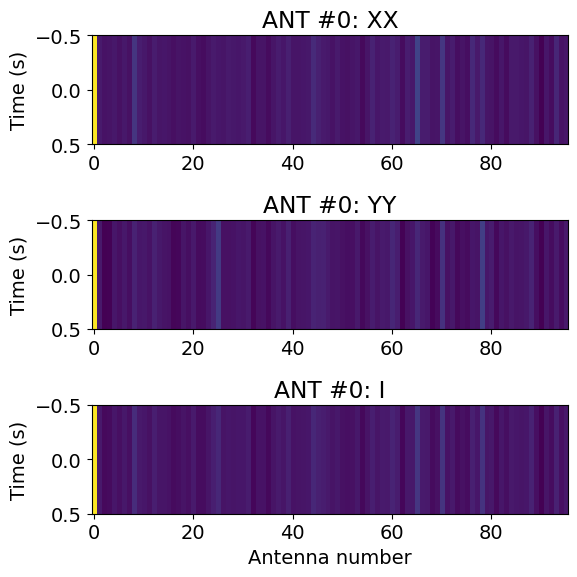

In [57]:
# Check how the various antennas/polarisation look with time
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=3, ncols=1, figsize=(6,6))

ax0.imshow(cube_xx[:, 0, :].real, aspect='auto')
ax0.set_ylabel('Time (s)')
ax0.set_title('ANT #0: XX')
ax1.imshow(cube_yy[:,0,:].real,aspect='auto')
ax1.set_title('ANT #0: YY')
ax1.set_ylabel('Time (s)')
ax2.imshow(visibilities_all[:,0,:].real,aspect='auto')
ax2.set_title('ANT #0: I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Time (s)')
fig1.tight_layout()

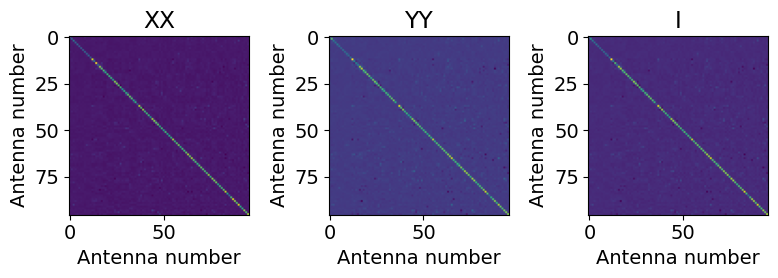

In [58]:
# Check how the correlations look
fig1, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, figsize=(8,3))

ax0.imshow(cube_xx[0,:,:].real, aspect='auto')
ax0.set_xlabel('Antenna number')
ax0.set_ylabel('Antenna number')
ax0.set_title('XX')
ax1.imshow(cube_yy[0,:,:].real, aspect='auto')
ax1.set_title('YY')
ax1.set_xlabel('Antenna number')
ax1.set_ylabel('Antenna number')
ax2.imshow(visibilities.real, aspect='auto')
ax2.set_title('I')
ax2.set_xlabel('Antenna number')
ax2.set_ylabel('Antenna number')
fig1.tight_layout()

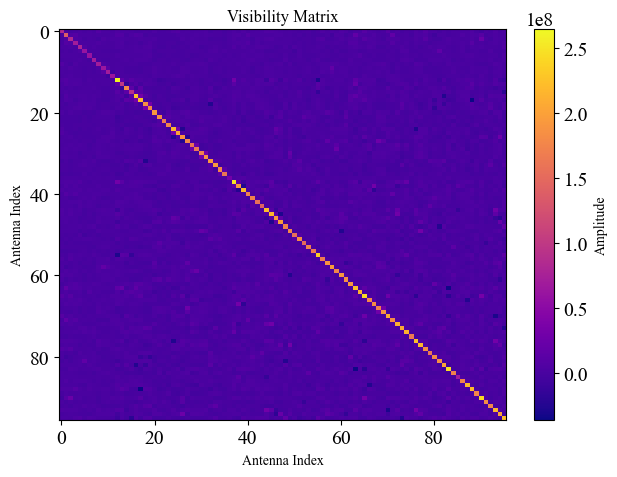

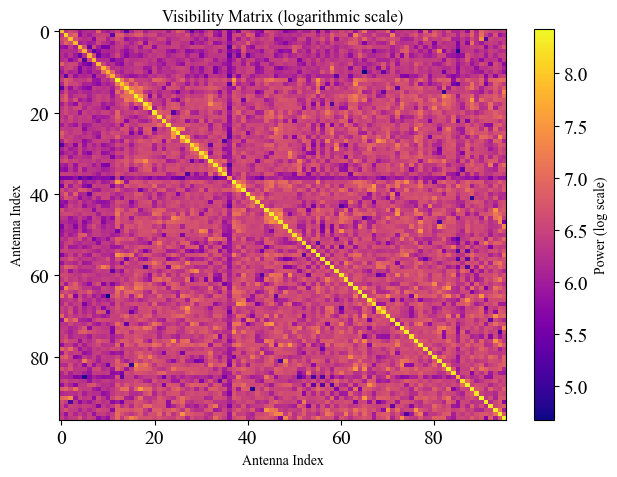

In [ ]:

plt.rcParams.update({
    'font.family': 'Times New Roman',
    'font.size': 14,
})


figures = []

# 1. Real Part of Visibility Matrix
fig1, ax1 = plt.subplots(figsize=(6.5, 5))
im1 = ax1.imshow(visibilities.real, aspect='auto', cmap='plasma')
cbar1 = fig1.colorbar(im1, ax=ax1)
cbar1.set_label('Amplitude', fontsize=10)
ax1.set_title('Visibility Matrix', fontsize=12)
ax1.set_xlabel('Antenna Index', fontsize=10)
ax1.set_ylabel('Antenna Index', fontsize=10)
fig1.tight_layout()
figures.append(fig1)

# 2. Log Power of Visibility Matrix
fig4, ax4 = plt.subplots(figsize=(6.5, 5))
log_power = np.log10(np.abs(visibilities)**1 + 1e-6)
im4 = ax4.imshow(log_power, aspect='auto', cmap='plasma')
cbar4 = fig4.colorbar(im4, ax=ax4)
cbar4.set_label('Power (log scale)', fontsize=10)
ax4.set_title('Visibility Matrix (logarithmic scale)', fontsize=12)
ax4.set_xlabel('Antenna Index', fontsize=10)
ax4.set_ylabel('Antenna Index', fontsize=10)
fig4.tight_layout()
figures.append(fig4)



#fig1.savefig("figure_1a.png", dpi=300, bbox_inches='tight')
#fig4.savefig("figure_1b.png", dpi=300, bbox_inches='tight')


In [60]:
# Setup the database
db = LofarAntennaDatabase()

In [61]:
station_xyz, pqr_to_xyz = get_station_xyz(station_name, rcu_mode, db)

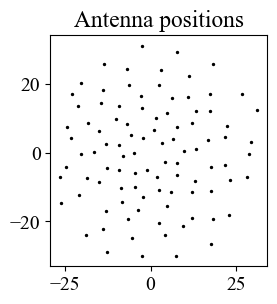

In [62]:
fig, ax = plt.subplots(figsize=(3, 3))
ax.scatter(station_xyz[:, 0], station_xyz[:, 1], s=2, facecolor='k');
ax.set_title("Antenna positions");
ax.set_aspect(1);

In [63]:
# For every antenna, calculate the distance between it and every other antenna
baselines = station_xyz[:, np.newaxis, :] - station_xyz[np.newaxis, :, :]

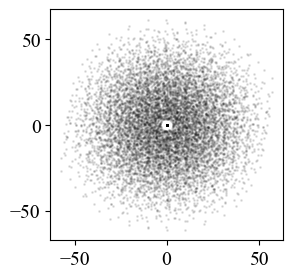

In [64]:
# Make a plot of the baselines contents (only U-V, not W)
# This gives the instantaneous U-V coverage of the LBA station
plt.figure(figsize=(3,3))
plt.scatter(baselines[:,:,0], baselines[:,:,1], facecolor='k', edgecolor='k', s=1, alpha=0.1);

In [65]:
# Account for the rotation
rotation = np.rad2deg(db.rotation_from_north(station_name))
print ('Rotation for %s: %.2f deg' % (station_name, rotation))

Rotation for LV614LBA: 12.73 deg


In [66]:
obstime_astropy = Time(obstime)
# Determine positions of Cas A and Cyg A
station_earthlocation = EarthLocation.from_geocentric(*(db.phase_centres[station_name] * u.m))
zenith = AltAz(az=0 * u.deg, alt=90 * u.deg, obstime=obstime_astropy,
               location=station_earthlocation).transform_to(GCRS(obstime=obstime_astropy))

marked_bodies = {
    'Cas A': SkyCoord(ra=350.85*u.deg, dec=58.815*u.deg),
    'Cyg A': SkyCoord(ra=299.868*u.deg, dec=40.734*u.deg),
        'Per A': SkyCoord.from_name("Perseus A"),
        'Her A': SkyCoord.from_name("Hercules A"),
        'Cen A': SkyCoord.from_name("Centaurus A"),
        '?': SkyCoord.from_name("J101415.9+105106"),
        '3C295': SkyCoord.from_name("3C295"),
        'Moon': get_moon(obstime_astropy, location=station_earthlocation).transform_to(GCRS(obstime=obstime_astropy)),
    'Sun': get_sun(obstime_astropy),
        '3C196': SkyCoord.from_name("3C196")
}

marked_bodies_lmn = {}
for body_name, body_coord in marked_bodies.items():
    #print(body_name, body_coord.separation(zenith), body_coord.separation(zenith))
    if body_coord.transform_to(AltAz(location=station_earthlocation, obstime=obstime_astropy)).alt > 0:
        marked_bodies_lmn[body_name] = skycoord_to_lmn(marked_bodies[body_name], zenith)

NameError: name 'get_moon' is not defined

In [ ]:
# Fourier transform
%time img = sky_imager(visibilities, baselines, freq, npix_l, npix_m)

In [ ]:
fig = make_sky_plot(img, marked_bodies_lmn, title=f"Sky image for {station_name}",
                    subtitle=f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}");

In [ ]:
fig.savefig(os.path.join('results', f'{fname}_sky_calibrated.png'), bbox_inches='tight', dpi=200)

In [ ]:
from lofarimaging.lofarimaging import subtract_sources

In [ ]:
visibilities_subtracted = subtract_sources(visibilities, baselines, freq, marked_bodies_lmn)

In [ ]:
img_subtracted = sky_imager(visibilities_subtracted, baselines, freq, npix_l, npix_m)

In [ ]:
fig = make_sky_plot(img_subtracted, marked_bodies_lmn, title=f"Sky image for {station_name}",
                    subtitle=f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}",
                    vmin=np.quantile(img_subtracted, 0.05));

In [ ]:
fig.savefig(os.path.join('results', f'{fname}_sky_calibrated_substracted.png'), bbox_inches='tight', dpi=200)

In [ ]:
plt.close(fig)

In [ ]:
npix_x, npix_y = int(ground_resolution * (extent[1] - extent[0])), int(ground_resolution * (extent[3] - extent[2]))

In [ ]:
os.environ["NUMEXPR_NUM_THREADS"] = "3"

In [ ]:
# Select a subset of visibilities, only the lower triangular part
baseline_indices = np.tril_indices(visibilities.shape[0])

In [ ]:
visibilities_selection = visibilities_subtracted[baseline_indices]

In [ ]:
%time img = nearfield_imager(visibilities_selection.flatten()[:,np.newaxis], \
                             np.array(baseline_indices).T, \
                             [freq], npix_x, npix_y, extent, station_xyz, height=height)
# Correct for taking only lower triangular part
img = np.real(2 * img)

In [ ]:
import lofargeotiff

In [ ]:
# Convert bottom left and upper right to PQR just for lofargeo
pmin, qmin, _ = pqr_to_xyz.T @ (np.array([extent[0], extent[2], 0]))
pmax, qmax, _ = pqr_to_xyz.T @ (np.array([extent[1], extent[3], 0]))
lon_center, lat_center, _ = lofargeotiff.pqr_to_longlatheight([0, 0, 0], station_name)
lon_min, lat_min, _ = lofargeotiff.pqr_to_longlatheight([pmin, qmin, 0], station_name)
lon_max, lat_max, _ = lofargeotiff.pqr_to_longlatheight([pmax, qmax, 0], station_name)
lon_min, lat_min, lon_max, lat_max

In [ ]:
background_map = get_map(lon_min, lon_max, lat_min, lat_max, 18)

In [ ]:
# Make colors semi-transparent in the lower 3/4 of the scale
cmap = cm.Spectral_r
cmap_with_alpha = cmap(np.arange(cmap.N))
cmap_with_alpha[:, -1] = np.clip(np.linspace(0, 1.5, cmap.N), 0., 1.)
cmap_with_alpha = ListedColormap(cmap_with_alpha)

In [ ]:
plt.imshow(img)

In [ ]:
fig, folium_overlay = make_ground_plot(img, background_map, extent,
                                       title=f"Near field image for {station_name}",
                                       subtitle=f"SB {subband} ({freq / 1e6:.1f} MHz), {str(obstime)[:16]}",
                                       opacity=0.3)

In [ ]:
fig.savefig(os.path.join('results', f'{fname}_near_field_uncalibrated.png'), bbox_inches='tight', dpi=200)

In [ ]:
maxpixel_ypix, maxpixel_xpix = np.unravel_index(np.argmax(img), img.shape)
maxpixel_x = np.interp(maxpixel_xpix, [0, npix_x], [extent[0], extent[1]])
maxpixel_y = np.interp(maxpixel_ypix, [0, npix_y], [extent[2], extent[3]])
[maxpixel_p, maxpixel_q, _] = pqr_to_xyz.T @ np.array([maxpixel_x, maxpixel_y, height])
maxpixel_lon, maxpixel_lat, _ = lofargeotiff.pqr_to_longlatheight([maxpixel_p, maxpixel_q], station_name)

In [ ]:
# Show location of maximum if not at the image border
if 5 < maxpixel_xpix < npix_x - 5 and 5 < maxpixel_ypix < npix_y - 5:
    print(f"Maximum at {maxpixel_x:.0f}m east, {maxpixel_y:.0f}m north of station center (lat/long {maxpixel_lat:.5f}, {maxpixel_lon:.5f})")

In [ ]:
# Check total time to run
end1 = time.time()
print ('Time elapsed: %.2f s' % (end1-start1))

Export the near field image to GeoTIFF for archiving and viewing in other tools (QGIS).

In [ ]:
obstime = datetime.datetime.strptime(obsdatestr + ":" + obstimestr, '%Y%m%d:%H%M%S')

In [ ]:
tags = {"datafile": xst_filename,
        "generated_with": f"lofarimaging notebook",
        "subband": subband,
        "frequency": freq,
        "extent_xyz": extent,
        "height": height,
        "station": station_name,
        "pixels_per_metre": pixels_per_metre}
tags.update(calibration_info)
lofargeotiff.write_geotiff(img, f"results/{fname}_nearfield_calibrated.tiff",
                           (pmin, qmin), (pmax, qmax), stationname=station_name,
                           obsdate=obstime, tags=tags)

Overlay the near field image on a map.

In [ ]:
make_leaflet_map(folium_overlay, lon_center, lat_center, lon_min, lat_min, lon_max, lat_max)